In [2]:
from google.colab import files
uploaded = files.upload()


Saving testnumba.jpeg to testnumba.jpeg


Time taken: 31.0427 seconds


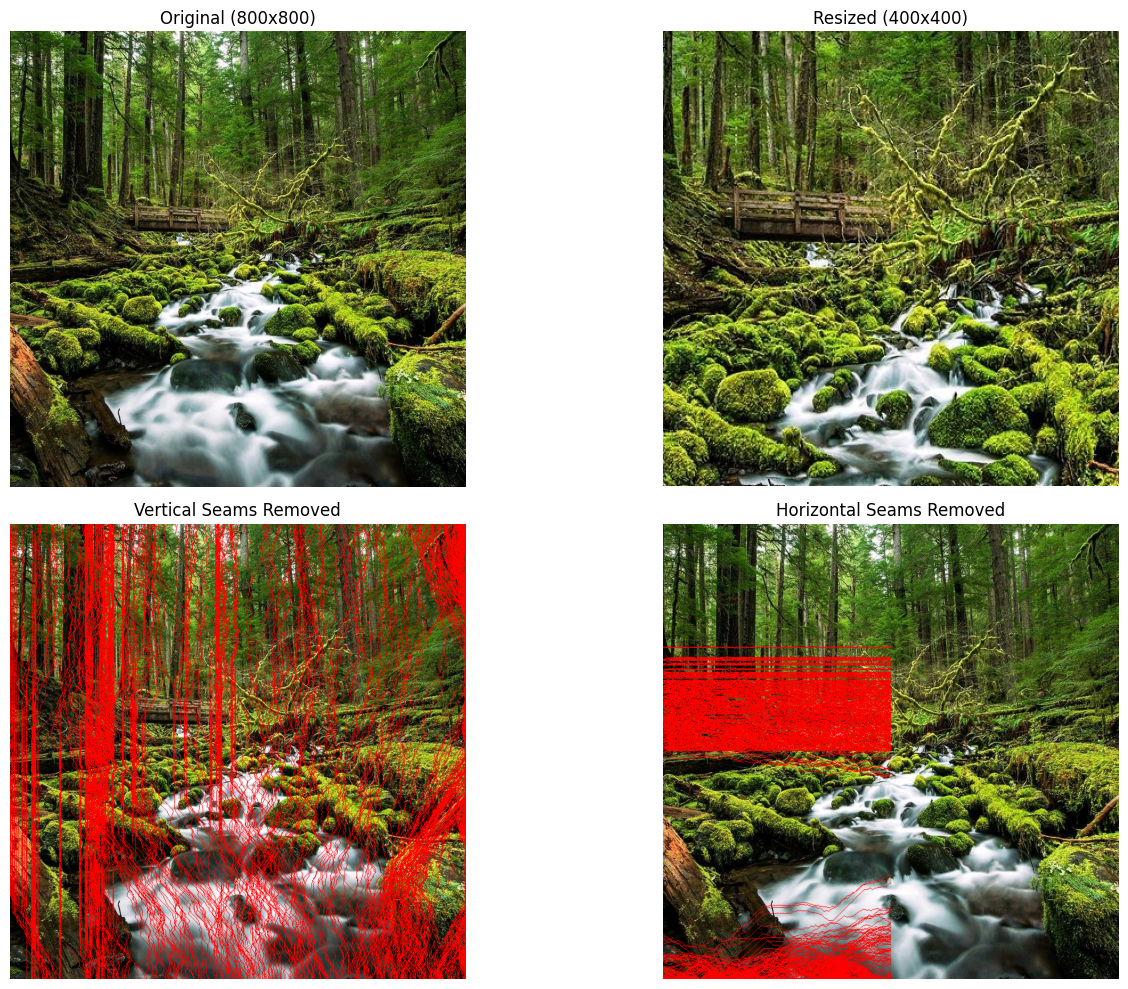

In [5]:
import numpy as np
import cv2
import numba as nb
from numba import njit, prange
import matplotlib.pyplot as plt
import time

class SeamCarver:
    def __init__(self, filename, out_height, out_width):
        # Initialize parameters
        self.filename = filename
        self.out_height = out_height
        self.out_width = out_width

        # Read image and convert to np.float64 format
        self.in_image = cv2.imread(filename).astype(np.float64)
        self.in_height, self.in_width = self.in_image.shape[:2]

        # Keep track of resulting image
        self.out_image = np.copy(self.in_image)

        # Kernels for forward energy map calculation
        self.kernel_x = np.array([[0., 0., 0.],
                                  [-1., 0., 1.],
                                  [0., 0., 0.]], dtype=np.float64)
        self.kernel_y_left = np.array([[0., 0., 0.],
                                       [0., 0., 1.],
                                       [0., -1., 0.]], dtype=np.float64)
        self.kernel_y_right = np.array([[0., 0., 0.],
                                        [1., 0., 0.],
                                        [0., -1., 0.]], dtype=np.float64)

        # Constant for masked areas (if needed)
        self.constant = 1000

        # Store seams for visualization
        self.vertical_seams = []
        self.horizontal_seams = []

        # Start seam carving
        self.seams_carving()

    def seams_carving(self):
        """
        Process seam removal in vertical direction and then horizontal (via rotation).
        """
        delta_row = int(self.out_height - self.in_height)
        delta_col = int(self.out_width - self.in_width)

        # Remove vertical seams if needed
        if delta_col < 0:
            self.seams_removal(-delta_col, vertical=True)

        # Remove horizontal seams if needed (rotate image for horizontal removal)
        if delta_row < 0:
            self.out_image = self.rotate_image(self.out_image, ccw=True)
            self.seams_removal(-delta_row, vertical=False)
            self.out_image = self.rotate_image(self.out_image, ccw=False)

    def seams_removal(self, num_pixel, vertical=True):
        """Remove a given number of seams from the image."""
        # Track removed pixels for coordinate adjustments
        removed_pixels = np.zeros((self.out_image.shape[0],), dtype=np.int32)

        for _ in range(num_pixel):
            energy_map = self.calc_energy_map()

            # Compute neighbor matrices using the defined kernels
            matrix_x = self.calc_neighbor_matrix(self.kernel_x)
            matrix_y_left = self.calc_neighbor_matrix(self.kernel_y_left)
            matrix_y_right = self.calc_neighbor_matrix(self.kernel_y_right)

            # Compute cumulative energy map using Numba-accelerated function
            cumulative_map = self._cumulative_map_forward_numba(energy_map,
                                                                  matrix_x,
                                                                  matrix_y_left,
                                                                  matrix_y_right)
            # Find seam using Numba-accelerated backtracking
            seam_idx = self._find_seam_numba(cumulative_map)

            # Map seam back to original coordinates and store for visualization
            if vertical:
                original_seam = np.copy(seam_idx)
                for i in range(len(original_seam)):
                    original_seam[i] += removed_pixels[i]
                self.vertical_seams.append(original_seam)

                for i in range(len(seam_idx)):
                    removed_pixels[i] += 1
            else:
                original_seam = np.copy(seam_idx)
                for i in range(len(original_seam)):
                    original_seam[i] += removed_pixels[i]
                self.horizontal_seams.append(original_seam)

                for i in range(len(seam_idx)):
                    removed_pixels[i] += 1

            # Remove the seam from the image using a Numba-optimized function
            self.delete_seam(seam_idx)

    def calc_energy_map(self):
        """Calculate energy map using gradient magnitude (Numba-accelerated)."""
        # Convert image to grayscale
        if self.out_image.shape[2] == 3:
            gray = cv2.cvtColor(self.out_image.astype(np.uint8),
                                cv2.COLOR_BGR2GRAY).astype(np.float64)
        else:
            gray = self.out_image[:, :, 0]
        return self._compute_energy_numba(gray)

    @staticmethod
    @njit(parallel=True)
    def _compute_energy_numba(channel):
        """Numba-accelerated gradient calculation for energy map."""
        h, w = channel.shape
        energy = np.zeros((h, w), dtype=np.float64)
        for i in prange(h):
            for j in range(w):
                # Compute horizontal gradient with boundary checks
                if j == 0:
                    dx = channel[i, j+1] - channel[i, j]
                elif j == w-1:
                    dx = channel[i, j] - channel[i, j-1]
                else:
                    dx = (channel[i, j+1] - channel[i, j-1]) / 2.0
                # Compute vertical gradient with boundary checks
                if i == 0:
                    dy = channel[i+1, j] - channel[i, j]
                elif i == h-1:
                    dy = channel[i, j] - channel[i-1, j]
                else:
                    dy = (channel[i+1, j] - channel[i-1, j]) / 2.0

                energy[i, j] = np.abs(dx) + np.abs(dy)
        return energy

    def cumulative_map_forward(self, energy_map):
        """
        Compute the cumulative energy map using forward energy calculation.
        (This method is not directly used because the Numba version is called.)
        """
        matrix_x = self.calc_neighbor_matrix(self.kernel_x)
        matrix_y_left = self.calc_neighbor_matrix(self.kernel_y_left)
        matrix_y_right = self.calc_neighbor_matrix(self.kernel_y_right)
        return self._cumulative_map_forward_numba(energy_map, matrix_x,
                                                  matrix_y_left, matrix_y_right)

    @staticmethod
    @njit
    def _cumulative_map_forward_numba(energy_map, matrix_x, matrix_y_left, matrix_y_right):
        """
        Numba-accelerated cumulative energy map calculation using forward energy.
        The algorithm remains the same as the original implementation.
        """
        m, n = energy_map.shape
        output = energy_map.copy()
        for row in range(1, m):
            for col in range(n):
                if col == 0:
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_right, e_up)
                elif col == n - 1:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_up)
                else:
                    e_left = output[row - 1, col - 1] + matrix_x[row - 1, col - 1] + matrix_y_left[row - 1, col - 1]
                    e_right = output[row - 1, col + 1] + matrix_x[row - 1, col + 1] + matrix_y_right[row - 1, col + 1]
                    e_up = output[row - 1, col] + matrix_x[row - 1, col]
                    output[row, col] = energy_map[row, col] + min(e_left, e_right, e_up)
        return output

    def calc_neighbor_matrix(self, kernel):
        """Apply a kernel to each color channel and sum the results."""
        if self.out_image.shape[2] == 3:
            b, g, r = cv2.split(self.out_image)
            output = np.abs(cv2.filter2D(b, -1, kernel=kernel)) + \
                     np.abs(cv2.filter2D(g, -1, kernel=kernel)) + \
                     np.abs(cv2.filter2D(r, -1, kernel=kernel))
        else:
            output = np.abs(cv2.filter2D(self.out_image[:, :, 0], -1, kernel=kernel))
        return output

    def find_seam(self, cumulative_map):
        """Find the optimal seam using the Numba-accelerated seam finding function."""
        return self._find_seam_numba(cumulative_map)

    @staticmethod
    @njit
    def _find_seam_numba(cumulative_map):
        """Numba-accelerated seam backtracking to find the optimal seam."""
        m, n = cumulative_map.shape
        output = np.empty(m, dtype=np.int32)
        # Find index of minimum energy in the last row
        min_idx = 0
        min_val = cumulative_map[m - 1, 0]
        for j in range(1, n):
            if cumulative_map[m - 1, j] < min_val:
                min_val = cumulative_map[m - 1, j]
                min_idx = j
        output[m - 1] = min_idx

        # Backtrack to find the seam path
        for row in range(m - 2, -1, -1):
            prev_col = output[row + 1]
            if prev_col == 0:
                if cumulative_map[row, 0] <= cumulative_map[row, 1]:
                    output[row] = 0
                else:
                    output[row] = 1
            elif prev_col == n - 1:
                if cumulative_map[row, n - 2] <= cumulative_map[row, n - 1]:
                    output[row] = n - 2
                else:
                    output[row] = n - 1
            else:
                c0 = cumulative_map[row, prev_col - 1]
                c1 = cumulative_map[row, prev_col]
                c2 = cumulative_map[row, prev_col + 1]
                if c0 <= c1 and c0 <= c2:
                    output[row] = prev_col - 1
                elif c1 <= c0 and c1 <= c2:
                    output[row] = prev_col
                else:
                    output[row] = prev_col + 1
        return output

    def delete_seam(self, seam_idx):
        """Delete the seam from the image using the Numba-accelerated deletion function."""
        self.out_image = self._delete_seam_numba(self.out_image, seam_idx)

    @staticmethod
    @njit
    def _delete_seam_numba(image, seam_idx):
        """Numba-accelerated function to remove the seam from the image."""
        m, n, c = image.shape
        out_img = np.empty((m, n - 1, c), dtype=image.dtype)
        for i in range(m):
            seam = seam_idx[i]
            # Copy pixels before the seam
            for j in range(seam):
                for k in range(c):
                    out_img[i, j, k] = image[i, j, k]
            # Copy pixels after the seam
            for j in range(seam, n - 1):
                for k in range(c):
                    out_img[i, j, k] = image[i, j + 1, k]
        return out_img

    def rotate_image(self, image, ccw):
        """Rotate the image 90 degrees counter-clockwise if ccw is True; otherwise, clockwise."""
        if ccw:
            return np.rot90(image)
        else:
            return np.rot90(image, k=-1)

    def save_result(self, filename):
        """Save the resulting image."""
        cv2.imwrite(filename, self.out_image.astype(np.uint8))

    def visualize_seams(self, output_path=None, seam_color=[0, 0, 255],
                         show_vertical=True, show_horizontal=True, max_seams=None):
        """
        Visualize the seams removed during the carving process.
        """
        orig_image = cv2.imread(self.filename)
        if orig_image is None:
            raise ValueError(f"Could not read image at {self.filename}")

        v_height, v_width = orig_image.shape[:2]
        vertical_vis = np.copy(orig_image) if show_vertical else None
        horizontal_vis = np.copy(orig_image) if show_horizontal else None

        if show_vertical and self.vertical_seams:
            seams_to_draw = self.vertical_seams[:max_seams] if max_seams else self.vertical_seams
            for seam in seams_to_draw:
                for row in range(min(len(seam), v_height)):
                    col = seam[row]
                    if 0 <= row < v_height and 0 <= col < v_width:
                        vertical_vis[row, col] = seam_color
            if output_path:
                cv2.imwrite(f"{output_path}_vertical.jpg", vertical_vis)

        if show_horizontal and self.horizontal_seams:
            seams_to_draw = self.horizontal_seams[:max_seams] if max_seams else self.horizontal_seams
            for seam in seams_to_draw:
                for col in range(min(len(seam), v_width)):
                    row = seam[col]
                    if 0 <= row < v_height and 0 <= col < v_width:
                        horizontal_vis[row, col] = seam_color
            if output_path:
                cv2.imwrite(f"{output_path}_horizontal.jpg", horizontal_vis)

        return vertical_vis, horizontal_vis

if __name__ == "__main__":
    # Change this path to your image location
    image_path = "/content/testnumba.jpeg"

    original = cv2.imread(image_path)
    if original is None:
        raise ValueError(f"Could not read image at {image_path}")

    orig_height, orig_width = original.shape[:2]
    target_width = int(orig_width * 0.5)
    target_height = int(orig_height * 0.5)

    start_time = time.perf_counter()

    # Create a SeamCarver instance
    carver = SeamCarver(image_path, out_height=target_height, out_width=target_width)

    end_time = time.perf_counter()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.4f} seconds")

    # Save the resized image
    carver.save_result("resized_image.jpg")

    # Visualize the seams removed
    vertical_vis, horizontal_vis = carver.visualize_seams(
        output_path="seams_visualization",
        max_seams=None  # Visualize all seams
    )

    # Plotting the results for comparison
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    rgb_original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_original)
    plt.title(f'Original ({orig_width}x{orig_height})')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    rgb_resized = cv2.cvtColor(carver.out_image.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_resized)
    plt.title(f'Resized ({target_width}x{target_height})')
    plt.axis('off')

    if vertical_vis is not None:
        plt.subplot(2, 2, 3)
        rgb_vertical = cv2.cvtColor(vertical_vis, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_vertical)
        plt.title('Vertical Seams Removed')
        plt.axis('off')

    if horizontal_vis is not None:
        plt.subplot(2, 2, 4)
        rgb_horizontal = cv2.cvtColor(horizontal_vis, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_horizontal)
        plt.title('Horizontal Seams Removed')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('comparison_visualization.png')
    plt.show()
